# Example Model

## Setup Environment

In [1]:
from pathlib import Path, PurePath

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
DATASET_URL="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

## Training Data

### Prepare Dataset

In [3]:
data_file = Path(
    tf.keras.utils.get_file(
        "cats_and_dogs.zip",
        origin=DATASET_URL,
        extract=True,
    )
)

data_dir = data_file.parent / "cats_and_dogs_filtered"
train_dir = data_dir / "train"
validation_dir = data_dir / "validation"

Path.mkdir(data_dir, exist_ok=True)
Path.mkdir(train_dir, exist_ok=True)
Path.mkdir(validation_dir, exist_ok=True)

In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)

Found 2000 files belonging to 2 classes.


In [15]:
eval_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)

eval_cardinality = tf.data.experimental.cardinality(eval_dataset)
test_dataset = eval_dataset.take(eval_cardinality // 5)
validation_dataset = eval_dataset.skip(eval_cardinality // 5)

Found 1000 files belonging to 2 classes.


### Configure Dataset

In [19]:
train_dataset__tuned = train_dataset.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE,
)

validation_dataset__tuned = validation_dataset.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE,
)

test_dataset__tuned = test_dataset.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE,
)

In [20]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### Explore Dataset

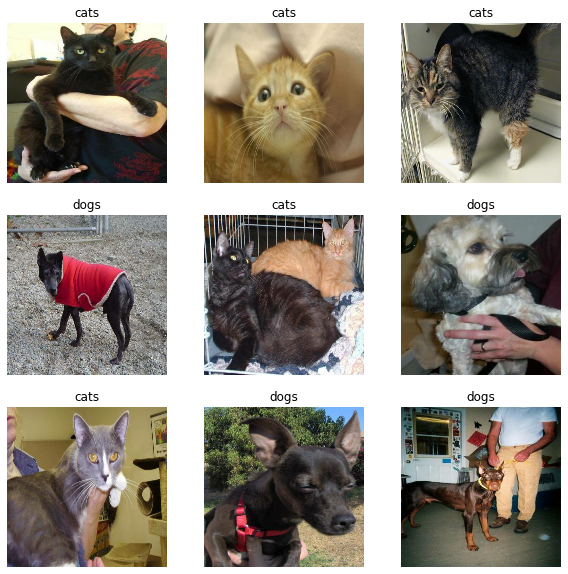

In [16]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_dataset.class_names[labels[i]])
        plt.axis("off")

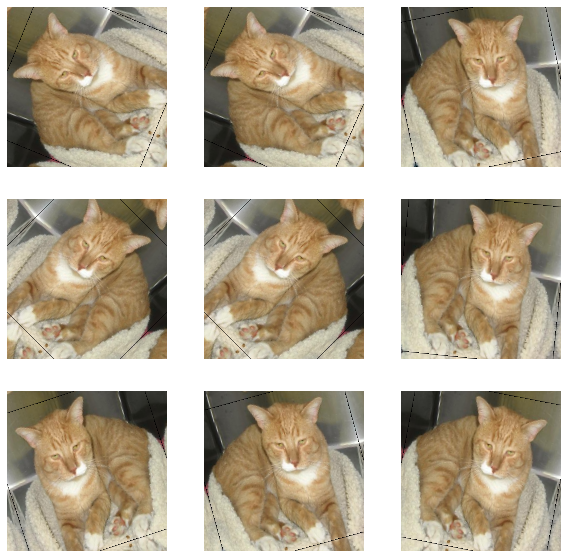

In [22]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

## Train Model

## References

* https://www.tensorflow.org/tutorials/images/transfer_learning